In [1]:
import pandas as pd
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab  
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
	
height = 419
width = 1
channels = 1
n_inputs = height * width

conv1_fmaps = 16
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 32
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

conv3_fmaps = 64
conv3_ksize = 3
conv3_stride = 2
conv3_pad = "SAME"


pool3_fmaps = conv2_fmaps


n_fc1 = 150
n_outputs = 2

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    keep_prob= tf.placeholder(tf.float32, shape=[], name="regularizer")

    X_drop=tf.nn.dropout(X,keep_prob)
#conv1_ksize size of filter
#conv1_stride step of filter
#padding weather boundary is exist 

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=[conv1_ksize,1],
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.elu, name="conv1")
pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1], padding="VALID")


conv2 = tf.layers.conv2d(pool1, filters=conv2_fmaps, kernel_size=[conv2_ksize,1],
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.elu, name="conv2")
conv2_drop=tf.nn.dropout(conv2,keep_prob)
pool2 = tf.nn.max_pool(conv2_drop, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1], padding="VALID")

conv3 = tf.layers.conv2d(pool2, filters=conv3_fmaps, kernel_size=[conv3_ksize,1],
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.elu, name="conv3")
conv3_drop=tf.nn.dropout(conv3,keep_prob)
pool3 = tf.nn.max_pool(conv3_drop, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1], padding="VALID")

pool3_flat = tf.reshape(pool3, shape=[-1, pool3.shape[1]*pool3.shape[2]*pool3.shape[3]])




with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.elu, name="fc1")
    fc1_drop=tf.nn.dropout(fc1,keep_prob)
with tf.name_scope("output"):
    logits = tf.layers.dense(fc1_drop, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y,name='obj-function')
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.


In [3]:

#writer = tf.summary.FileWriter("logs/", sess.graph)    
print(X)
print(X_reshaped)
print(conv1)
print(conv2)
print(pool3)
print(pool3_flat)

Tensor("inputs/X:0", shape=(?, 419), dtype=float32)
Tensor("inputs/Reshape:0", shape=(?, 419, 1, 1), dtype=float32)
Tensor("conv1/Elu:0", shape=(?, 419, 1, 16), dtype=float32)
Tensor("conv2/Elu:0", shape=(?, 105, 1, 32), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 13, 1, 64), dtype=float32)
Tensor("Reshape:0", shape=(?, 832), dtype=float32)


In [4]:
def Scaler(x1):
    x=x1[1:]
    maximun=max(x)
    minimun=min(x)
    for i in range(len(x)):
        x[i]=(x[i]-minimun)/(maximun-minimun)
        x1[i+1]=x[i]*0.99+0.01
    return x1
    
def prodata(train_data_list):
    data=[]
    for record in train_data_list:
        all_value=record.split(',')
        #print((all_value))
        inputs=(np.asfarray(all_value))
        #inputs=Scaler(inputs)
        data.append(inputs)
    return np.array(data)



def getaccurancy(Y_proba,label_y):
    k=0
    k1=0
    s=0
    for i in range(len(label_y)):
        if(label_y[i]==1):
            s=s+1
    for i in range(len(label_y)):
        if(label_y[i]==1 and Y_proba[i][1]>Y_proba[i][0]):
            k1=k1+1
    for i in range(len(label_y)):
        if(Y_proba[i][1]>Y_proba[i][0]):
            k=k+1
    if(k!=0):
        return float(k1)/k,float(k1)/s
    else:
        return 0,float(k1)/s

# data_file=open('traindata_r.dat','r')
# data_list=data_file.readlines()
# data_file.close()
# train_data,test_data=train_test_split(data_list,test_size=0.25)


train_data_file=open('train/train3','r')
train_data_list=train_data_file.readlines()
train_data_file.close()
test_data_file=open('train/test3','r')
test_data_list=test_data_file.readlines()
test_data_file.close()
train_data=prodata(train_data_list)
test_data=prodata(test_data_list)



X_train = train_data[:,1:].astype(np.float32)
X_test = test_data[:,1:].astype(np.float32)
y_train = train_data[:,0].astype(np.int32)
y_test = test_data[:,0].astype(np.int32)

In [5]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#tem = sess.run(keep_prob,feed_dict={X: X_train, y: y_train,keep_prob:1.0})

In [6]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

batch_size = 300


index=[]
loss_train_arr=[]
loss_test_arr=[]
acc_train_arr=[]
acc_test_arr=[]
rec_train_arr=[]
rec_test_arr=[]

f=open('RMS.dat','w')
for epoch in range(70):
    
    loss_train = sess.run(loss,feed_dict={X: X_train, y: y_train,keep_prob:1.0})
    loss_test = sess.run(loss,feed_dict={X: X_test, y: y_test,keep_prob:1.0})
    Yproba_train =sess.run(Y_proba,feed_dict={X: X_train, y: y_train,keep_prob:1.0})
    Yproba_test = sess.run(Y_proba,feed_dict={X: X_test, y: y_test,keep_prob:1.0})
    #acc_train=sess.run(accuracy,feed_dict={X: X_train, y: y_train,keep_prob:False})
    #acc_test=sess.run(accuracy,feed_dict={X: X_test, y: y_test,keep_prob:False})
    acc_train,recall_train=getaccurancy(Yproba_train,y_train)
    acc_test,recall_test=getaccurancy(Yproba_test,y_test)
    
    f.write('%d %f %f %f %f %f %f\n' %(epoch,loss_train,loss_test,acc_train,acc_test,recall_train,recall_test))
    index.append(epoch)
    loss_train_arr.append(loss_train)
    loss_test_arr.append(loss_test)
    acc_train_arr.append(acc_train)
    acc_test_arr.append(acc_test)
    rec_train_arr.append(recall_train)
    rec_test_arr.append(recall_test)
    #pre = sess.run(logits,feed_dict={X: X_batch, y: y_batch})
    #if(epoch%5==0):
    print(epoch,'train loss:','Losstrain:',round(loss_train,3),'test loss:',round(loss_test,3))
    print(epoch, 'train accurancy:',round(acc_train,3) ,'test accurancy:',round(acc_test,3),'train recall',round(recall_train,3),'test recall',round(recall_test,3))
    logitsout = sess.run(logits,feed_dict={X: X_test, y: y_test,keep_prob:1.0})

    if(epoch!=100):
        for X_batch, y_batch in shuffle_batch(X_train,y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch,keep_prob:0.75})
f.close()    

0 train loss: Losstrain: 0.707 test loss: 0.709
0 train accurancy: 0.095 test accurancy: 0.096 train recall 0.061 test recall 0.059
1 train loss: Losstrain: 0.348 test loss: 0.443
1 train accurancy: 0.801 test accurancy: 0.813 train recall 0.9 test recall 0.897
2 train loss: Losstrain: 0.259 test loss: 0.311
2 train accurancy: 0.815 test accurancy: 0.828 train recall 0.922 test recall 0.925
3 train loss: Losstrain: 0.251 test loss: 0.274
3 train accurancy: 0.803 test accurancy: 0.813 train recall 0.932 test recall 0.935
4 train loss: Losstrain: 0.248 test loss: 0.255
4 train accurancy: 0.797 test accurancy: 0.803 train recall 0.939 test recall 0.943
5 train loss: Losstrain: 0.254 test loss: 0.256
5 train accurancy: 0.789 test accurancy: 0.794 train recall 0.945 test recall 0.953
6 train loss: Losstrain: 0.263 test loss: 0.259
6 train accurancy: 0.775 test accurancy: 0.781 train recall 0.958 test recall 0.96
7 train loss: Losstrain: 0.234 test loss: 0.23
7 train accurancy: 0.799 test ac

62 train loss: Losstrain: 0.086 test loss: 0.139
62 train accurancy: 0.925 test accurancy: 0.909 train recall 0.976 test recall 0.955
63 train loss: Losstrain: 0.082 test loss: 0.149
63 train accurancy: 0.936 test accurancy: 0.917 train recall 0.97 test recall 0.948
64 train loss: Losstrain: 0.093 test loss: 0.148
64 train accurancy: 0.915 test accurancy: 0.9 train recall 0.979 test recall 0.957
65 train loss: Losstrain: 0.088 test loss: 0.15
65 train accurancy: 0.915 test accurancy: 0.898 train recall 0.982 test recall 0.961
66 train loss: Losstrain: 0.082 test loss: 0.145
66 train accurancy: 0.934 test accurancy: 0.909 train recall 0.97 test recall 0.946
67 train loss: Losstrain: 0.079 test loss: 0.137
67 train accurancy: 0.931 test accurancy: 0.907 train recall 0.977 test recall 0.951
68 train loss: Losstrain: 0.08 test loss: 0.147
68 train accurancy: 0.93 test accurancy: 0.908 train recall 0.979 test recall 0.953
69 train loss: Losstrain: 0.075 test loss: 0.139
69 train accurancy: 

In [7]:
saver=tf.train.Saver()
saver.save(sess,'model/RFTN3-2.21.ckpt')

'model/RFTN3-2.21.ckpt'

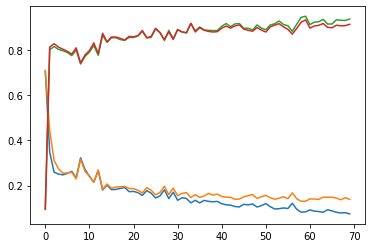

In [8]:
f=open('logit.dat','w')
for i in range(len(logitsout)):
    #if(y_test[i]==1):
    f.write('%f %f %f\n' %(logitsout[i][0],logitsout[i][1],y_test[i]))
f.close()

plt.plot(loss_train_arr)
plt.plot(loss_test_arr)
plt.plot(acc_train_arr)
plt.plot(acc_test_arr)
plt.show() 